In [41]:
# Package Imports
import pandas as pd
import numpy as np
import pickle

from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, make_scorer, recall_score, accuracy_score, precision_score, f1_score, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, ParameterGrid, GridSearchCV, cross_validate, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier

from imblearn.pipeline import Pipeline as ImPipeline

import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.text import Tokenizer

# Modeling

In [25]:
max_features = 100000

In [3]:
# Read in the data
df = pd.read_csv('../data/train_cleaned.csv', usecols=['sentiment', 'text_cleaned', 'toks'])

In [4]:
df.head(25)

,sentiment,text_cleaned,toks
0,2,lovely pat one great voice generation listen c...,"['lovely', 'pat', 'one', 'great', 'voice', 'ge..."
1,2,despite fact play small portion game music hea...,"['despite', 'fact', 'play', 'small', 'portion'..."
2,1,bought charger jul work ok design nice conveni...,"['bought', 'charger', 'jul', 'work', 'ok', 'de..."
3,2,check maha energy's website powerex mh c f cha...,"['check', 'maha', ""energy's"", 'website', 'powe..."
4,2,review quite bit combo player hesitant due unf...,"['review', 'quite', 'bit', 'combo', 'player', ..."
5,1,also begin incorrect disc problem i've read vc...,"['also', 'begin', 'incorrect', 'disc', 'proble..."
6,1,love style couple year dvd give problem even w...,"['love', 'style', 'couple', 'year', 'dvd', 'gi..."
7,1,cannot scroll dvd menu set vertically triangle...,"['cannot', 'scroll', 'dvd', 'menu', 'set', 've..."
8,2,exotic tale orient dr shen fu weird tale magaz...,"['exotic', 'tale', 'orient', 'dr', 'shen', 'fu..."
9,1,firstly enjoy format tone book author address ...,"['firstly', 'enjoy', 'format', 'tone', 'book',..."


In [5]:
print(df.isna().sum())
df[df['text_cleaned'].isna()]

sentiment       0
text_cleaned    1
toks            0
dtype: int64


,sentiment,text_cleaned,toks
369851,2,NaN,[]


In [6]:
# Drop lone NaN value in 'text_cleaned'
df.dropna(inplace=True)

In [7]:
X = df['text_cleaned']
y = df['sentiment']

In [80]:
# Instantiate Dummy Classifier pipeline
dummy_pipe = ImPipeline(steps=[
                                ('vect', TfidfVectorizer(max_features=max_features)),
                                ('dc', DummyClassifier(strategy='most_frequent',
                                                           random_state=42))
                              ]
)

/Users/tom/opt/anaconda3/envs/spark-cap-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


0.500001250003125


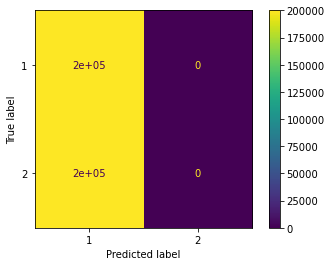

In [81]:
# Fit dummy pipe on the training data and plot confusion matrix
dummy_pipe.fit(X, y)
dummy_yhat = dummy_pipe.predict(X)
plot_confusion_matrix(dummy_pipe, X, y);
print(accuracy_score(y, dummy_yhat))

/Users/tom/opt/anaconda3/envs/spark-cap-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


0.8430846077115193


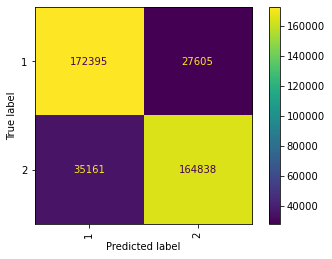

In [23]:
# Instantiate the Multinomial Naieve Bayes Pipeline
mnb_pipe = ImPipeline(steps=[
                            ('vect', TfidfVectorizer(max_features=max_features)),
                            ('mnb', MultinomialNB())
                            ]
)

# Fit MNB pipe on the training data, get predictions and plot confusion matrix
mnb_pipe.fit(X, y)
mnb_yhat = mnb_pipe.predict(X)
plot_confusion_matrix(mnb_pipe, X, y, xticks_rotation=90);
print(accuracy_score(y, mnb_yhat))

In [24]:
mnb_pipe.named_steps['mnb'].n_features_
#__mnb.n_features_

/Users/tom/opt/anaconda3/envs/spark-cap-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


218195

In [9]:
# Obtained cross-validated accuracy score
cross_validate(mnb_pipe, X, y)

{'fit_time': array([7.06104302, 7.00558996, 6.90852499, 6.96033812, 7.03689289]),
 'score_time': array([1.86571383, 1.81603718, 1.78075004, 1.75291896, 1.78729224]),
 'test_score': array([0.8159125 , 0.8130375 , 0.8154875 , 0.8105875 , 0.81017263])}

In [96]:
# Instantiate the Random Forest Pipeline
rf_pipe = ImPipeline(steps=[
                            ('vect', TfidfVectorizer(max_features=max_features)),
                            ('rf', RandomForestClassifier())
                            ]
)

# Fit RF pipe on the training data, get predictions and plot confusion matrix
# rf_pipe.fit(X, y)
rf_yhat = rf_pipe.predict(X)
plot_confusion_matrix(rf_pipe, X, y);
print(accuracy_score(y, rf_yhat))

NotFittedError: The TF-IDF vectorizer is not fitted

In [86]:
# Obtained cross-validated accuracy score
# cross_validate(rf_pipe, X, y)

{'fit_time': array([1830.52545214, 1831.86812997, 1832.6002512 , 1840.15665793,
        1856.76238298]),
 'score_time': array([8.741611  , 8.63665485, 8.63135886, 8.6168921 , 8.63820219]),
 'test_score': array([0.836875  , 0.8388375 , 0.839625  , 0.839225  , 0.84041051])}

In [88]:
with open ('rf_pkl', 'wb') as files:
    pickle.dump(rf_pipe, files)

/Users/tom/opt/anaconda3/envs/spark-cap-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


0.8553321383303458


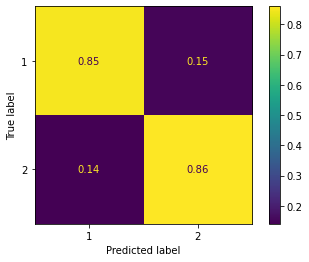

In [57]:
# Instantiate the SDGC Classifier pipeline
sgdc_pipe = ImPipeline(steps=[
                            ('vect', TfidfVectorizer(max_features=max_features,
                                                    #max_df=0.95,
                                                   # min_df=0.05
                                                    )),
                            ('sgdc', SGDClassifier(random_state=42))
                            ]
)

#Fit SGDC pipe on the training data, get predictions and plot confusion matrix
sgdc_pipe.fit(X, y)
sgdc_yhat = sgdc_pipe.predict(X)
plot_confusion_matrix(sgdc_pipe, X, y, normalize='true');
print(accuracy_score(y, sgdc_yhat))

In [40]:
# Obtained cross-validated accuracy score
cross_validate(sgdc_pipe, X, y)

{'fit_time': array([7.67305493, 8.02314401, 7.59999084, 7.95747113, 8.13202381]),
 'score_time': array([2.0716188 , 1.85317802, 1.77932596, 1.80910516, 1.81775713]),
 'test_score': array([0.8476125 , 0.8511    , 0.85025   , 0.8506125 , 0.85202315])}

In [64]:
sgdc_params = {
            'sgdc__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 0.0002, 0.0005],
            #'sgdc__n_iter': [50, 100, 500],
            'sgdc__loss': ['hinge', 'log', 'huber'],
            'sgdc__penalty': ['l2', 'l1', 'elasticnet'],
            'vect__max_features': [None, 50000, 100000, 200000]
             }

In [65]:
sgdc_gs = GridSearchCV(sgdc_pipe, param_grid=sgdc_params, n_jobs=-2, verbose=3, cv=3)
sgdc_gs.fit(X, y)

Fitting 3 folds for each of 360 candidates, totalling 1080 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(max_features=50000)),
                                       ('sgdc',
                                        SGDClassifier(loss='log',
                                                      random_state=42))]),
             n_jobs=-2,
             param_grid={'sgdc__alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0,
                                         100.0, 1000.0, 0.0002, 0.0005],
                         'sgdc__loss': ['hinge', 'log', 'huber'],
                         'sgdc__penalty': ['l2', 'l1', 'elasticnet'],
                         'vect__max_features': [None, 50000, 100000, 200000]},
             verbose=3)

In [66]:
sgdc_gs.best_params_

{'sgdc__alpha': 0.0001,
 'sgdc__loss': 'hinge',
 'sgdc__penalty': 'l2',
 'vect__max_features': 50000}

/Users/tom/opt/anaconda3/envs/spark-cap-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


0.8555021387553469


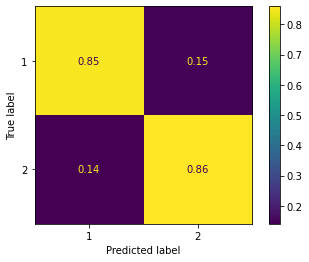

In [67]:
# Instantiate the SDGC Classifier pipeline
sgdc_tuned_pipe = ImPipeline(steps=[
                            ('vect', TfidfVectorizer(max_features=50000,
                                                    #max_df=0.95,
                                                   # min_df=0.05
                                                    )),
                            ('sgdc', SGDClassifier(random_state=42,
                                                  alpha=0.0001,
                                                  loss = 'hinge',
                                                  penalty='l2'
                                                  ))
                            ]
)

#Fit SGDC pipe on the training data, get predictions and plot confusion matrix
sgdc_tuned_pipe.fit(X, y)
sgdc_tuned_yhat = sgdc_tuned_pipe.predict(X)
plot_confusion_matrix(sgdc_tuned_pipe, X, y, normalize='true');
print(accuracy_score(y, sgdc_tuned_yhat))

/Users/tom/opt/anaconda3/envs/spark-cap-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


0.7664144160360401


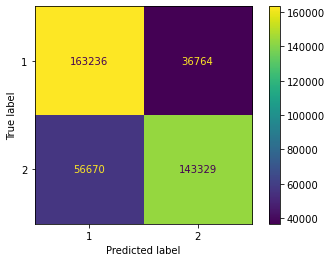

In [99]:
# Instantiate the gradient boosting classifier pipeline
gbc_pipe = ImPipeline(steps=[
                                 ('vect', TfidfVectorizer(max_features=max_features)),
                                 ('gbc',  GradientBoostingClassifier())
                                ]
)

#Fit SGDC pipe on the training data, get predictions and plot confusion matrix
gbc_pipe.fit(X, y)
gbc_yhat = gbc_pipe.predict(X)
plot_confusion_matrix(gbc_pipe, X, y);
print(accuracy_score(y, gbc_yhat))

In [100]:
# Obtained cross-validated accuracy score
cross_validate(gbc_pipe, X, y)

{'fit_time': array([285.57566977, 286.21229815, 289.5758419 , 286.79738688,
        288.09794784]),
 'score_time': array([1.75061703, 1.73659492, 1.71818924, 1.70788002, 1.71104002]),
 'test_score': array([0.7638125, 0.762975 , 0.7638875, 0.7671625, 0.7679971])}

In [121]:
X

0         lovely pat one great voice generation listen c...
1         despite fact play small portion game music hea...
2         bought charger jul work ok design nice conveni...
3         check maha energy's website powerex mh c f cha...
4         review quite bit combo player hesitant due unf...
                                ...                        
399995    buy thomas son huge thomas fan huge set room t...
399996    son recieved birthday gift month ago love even...
399997    buy toy son love thomas toys need one battery ...
399998    compilation wide range mitford's article best ...
399999    dvd disappointment get hop see substantial por...
Name: text_cleaned, Length: 399999, dtype: object

In [9]:
tokenizer = Tokenizer(oov_token="<OOV>")
tokens = tokenizer.fit_on_texts(X)

# Turn text into sequences (word --> num )
text_sequences = tokenizer.texts_to_sequences(X)
# Turn text sequences into tf-idf sequences
tfidf_train = tokenizer.sequences_to_matrix(text_sequences , mode='tfidf')

In [10]:
tfidf_train

array([[0.        , 0.        , 1.57169084, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [11]:
model = Sequential()
model

In [12]:
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [13]:
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                780       
                                                                 
 dense_1 (Dense)             (None, 8)                 104       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 893
Trainable params: 893
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(tfidf_train, y, epochs=5, batch_size=10)

In [ ]:
y.shape

In [ ]:
X.shape